## Kaggle: Russian Housing Market

### This projects builds and trains a Machine Learning model to predict housing prices.

## Things to Add

- recursive feature selection
- grid search for xgboost

## Load Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

import sys
print(sys.version)

from tensorflow.python.client import device_lib
print (device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
device: 0, name: GeForce GT 730M, pci bus id: 0000:01:00.0 /gpu:0


## Dataset Summary

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
macro = pd.read_csv('./input/macro.csv')
id_test = test['id']

valid_split = int(0.8*train.shape[0])
valid = train.ix[valid_split+1:]
train = train.ix[:valid_split]

# train = pd.concat((train,valid)) # use for final model

In [3]:
def display_summary_info():
    n_train = len(train)
    n_valid = len(valid)
    n_test = len(test)
    n_total = n_train + n_valid + n_test
    
    print("Training examples =", n_train)
    print("Validation examples =", n_valid)
    print("Testing examples =", n_test,'\n')
    
    print('% Training =',np.round(100*n_train/(n_train+n_valid+n_test),0))
    print('% Validation =',np.round(100*n_valid/(n_train+n_valid+n_test),0))
    print('% Testing =',np.round(100*n_test/(n_train+n_valid+n_test),0))
    
    print ('\ntrain dates:',train.iloc[0,1] + ' --> ' + train.iloc[-1,1])
    print ('valid dates:',valid.iloc[0,1] + ' --> ' + valid.iloc[-1,1])
    print ('test dates:',test.iloc[0,1] + ' --> ' + test.iloc[-1,1])
    return None

if (1): display_summary_info()

Training examples = 24377
Validation examples = 6094
Testing examples = 7662 

% Training = 64.0
% Validation = 16.0
% Testing = 20.0

train dates: 2011-08-20 --> 2014-11-06
valid dates: 2014-11-06 --> 2015-06-30
test dates: 2015-07-01 --> 2016-05-30


## Exploratory Visualization: Housing Prices

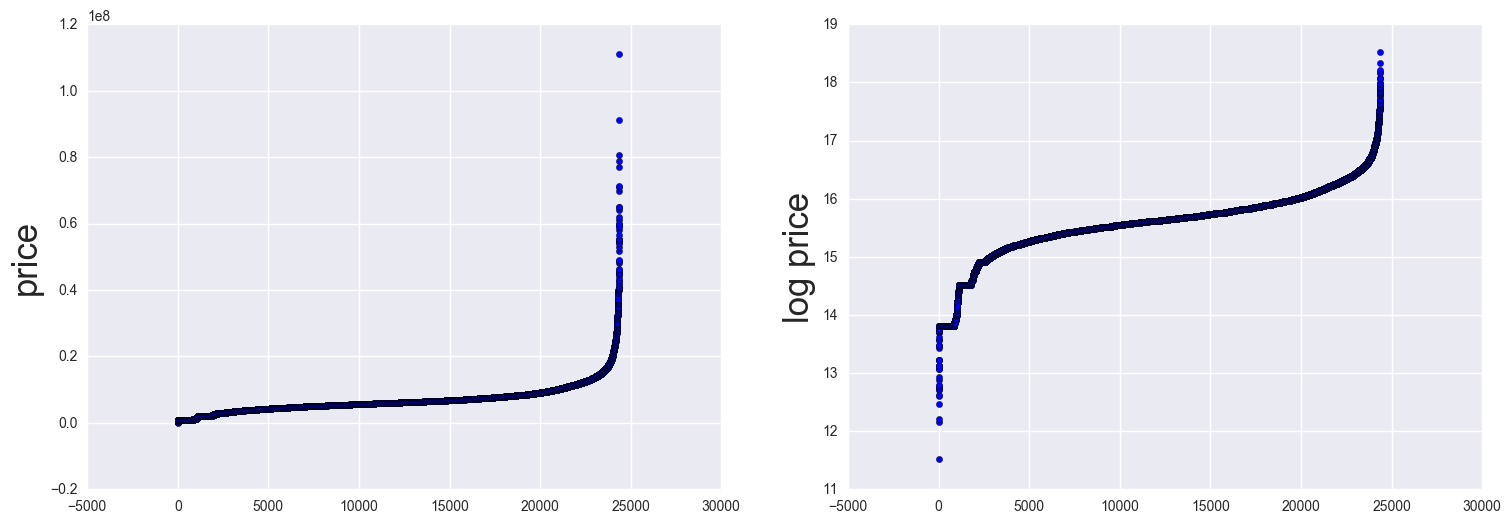

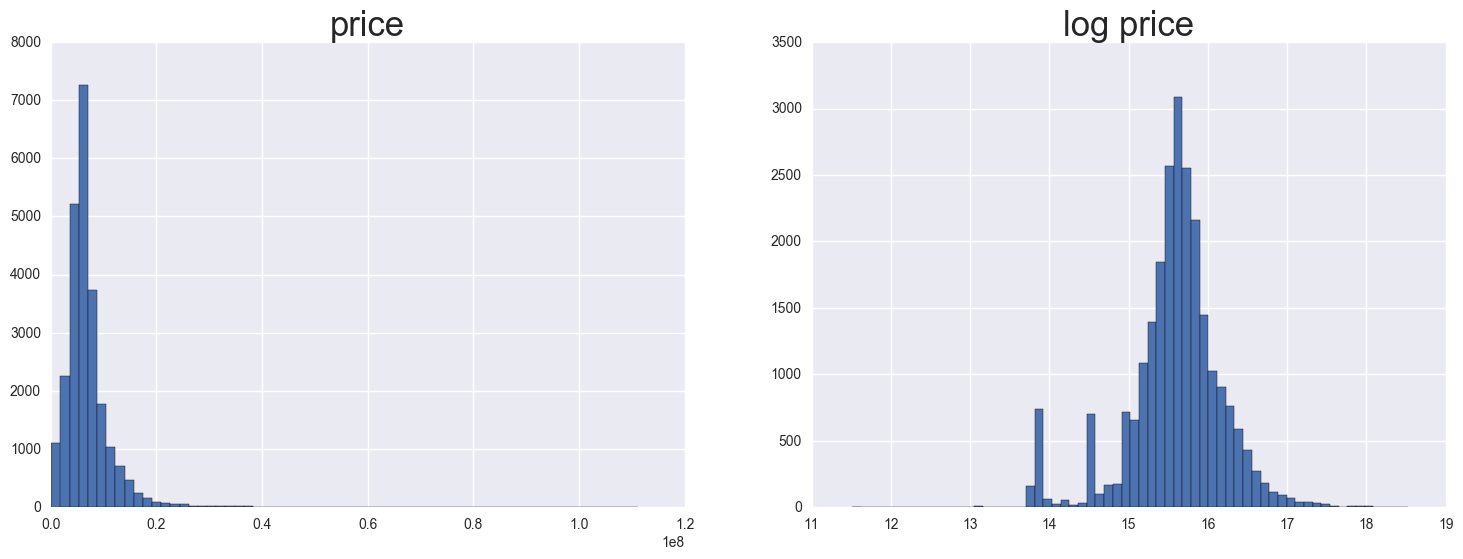

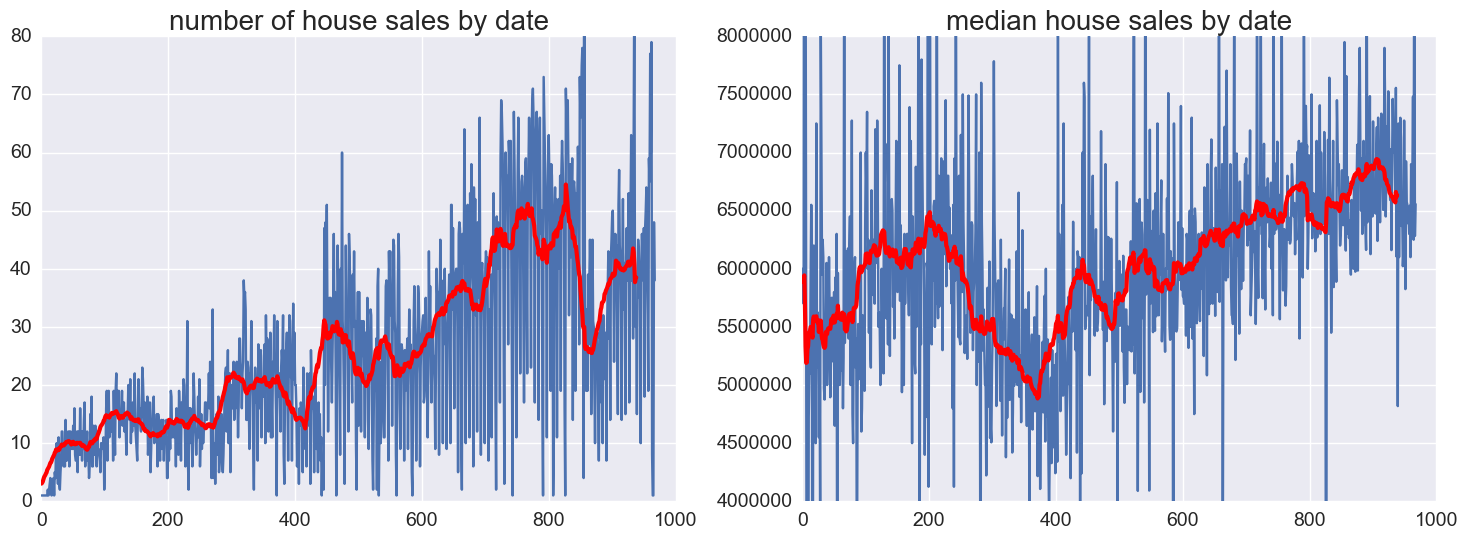

In [4]:
def plot_prices():
    price = train['price_doc']
    log_price = np.log1p(price
                    )
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    #plt.xlabel('index',fontsize=25)
    plt.ylabel('price',fontsize=25)
    plt.scatter(range(len(train)), np.sort(price))
    plt.subplot(1,2,2)
    #plt.xlabel('index',fontsize=25)
    plt.ylabel('log price',fontsize=25)
    plt.scatter(range(len(train)), np.sort(log_price))
    plt.show()

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('price', fontsize=25)
    hist = plt.hist(price, bins=64)[0]
    plt.subplot(1,2,2)
    plt.title('log price', fontsize=25)
    hist = plt.hist(log_price, bins=64)[0]
    plt.show()

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_sales_by_date():
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.tick_params(labelsize=14)
    unique = train.pivot_table(index=['timestamp'],aggfunc='count')
    plt.ylim(0,80)
    plt.title('number of house sales by date',fontsize=20)
    plt.plot(unique['price_doc'].values)
    plt.plot(moving_average(unique['price_doc'].values,30),lw=3,color='r')

    plt.subplot(1,2,2)
    plt.tick_params(labelsize=14)
    unique = train.pivot_table(index=['timestamp'],aggfunc='median')
    plt.ylim(0.4e7,0.8e7)
    plt.title('median house sales by date',fontsize=20)
    plt.plot(unique['price_doc'].values)
    plt.plot(moving_average(unique['price_doc'].values,30),lw=3,color='r')

if (1): plot_prices()
if (1): plot_sales_by_date()

## Exploratory Visualization: Macro Economic Features


Number of macro economic features: 2484
Number of columns which have any NaN: 51 / 292
Number of rows which have any NaN: 20051 / 24377


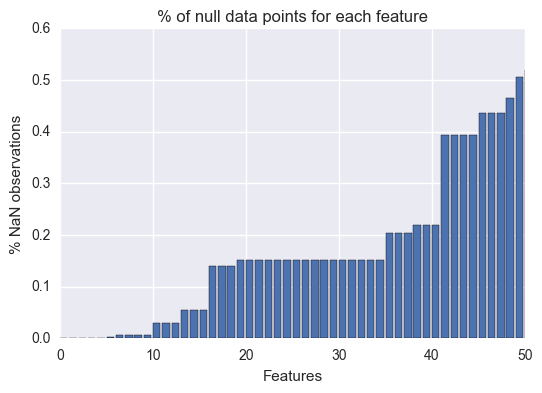

In [5]:
print('\nNumber of macro economic features:',macro.shape[0])
print('Number of columns which have any NaN:',train.isnull().any().sum(),'/',len(train.columns))
print('Number of rows which have any NaN:',train.isnull().any(axis=1).sum(),'/',len(train))

def plot_null_features():
    ranking = train.loc[:,train.isnull().any()].isnull().sum().sort_values()
    x = ranking.values/len(train)
    index = np.arange(len(ranking))
    
    plt.bar(index, x)
    plt.xlim(0,50)
    plt.xlabel('Features')
    plt.ylabel('% NaN observations')
    plt.title('% of null data points for each feature')
    plt.show()

if (1): plot_null_features()

## Preprocess Data: Macro Economic Features

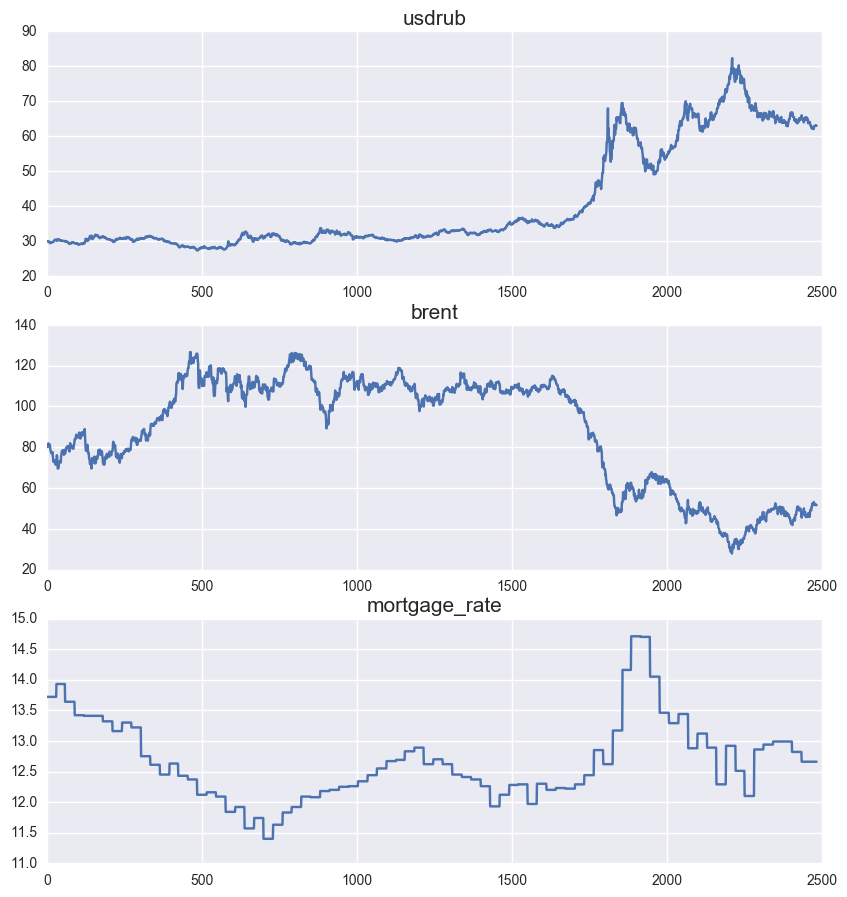

In [6]:
macro_feat = ['oil_urals','usdrub','brent','rts','micex','micex_rgbi_tr','deposits_rate','mortgage_growth','mortgage_rate',
             'rent_price_4+room_bus','rent_price_3room_bus','rent_price_2room_bus','rent_price_1room_bus',
             'rent_price_3room_eco','rent_price_2room_eco','rent_price_1room_eco']

df = macro[['timestamp'] + macro_feat].copy()
#df = macro

# some macro data are missing first values --> replacing nan with first good value
for feat in macro_feat:
    first_index = df[feat].first_valid_index()
    if first_index != 0:
        df[feat] = df[feat].fillna(df[feat][first_index])
    #print (macro[feat].first_valid_index(),feat,macro[feat].isnull().sum())

# if less than (or equal) 292 columns, we have not merged with macro yet
if train.shape[1] <= 292:
    train = pd.merge(train, df, on='timestamp', how='left')
    test = pd.merge(test, df, on='timestamp', how='left')

if (1):
    plt.figure(figsize=(10,60))
    counter = 0
    for feat in ['usdrub','brent','mortgage_rate']: # macro_feat:
        counter += 1
        plt.subplot(len(macro_feat),1,counter)
        plt.title(feat, fontsize=15)
        plt.tick_params(labelsize=10)
        plt.plot(df.index, df[feat])
    plt.show()

## Model Architecture: XGBoost

In [7]:
def get_xgboost_results():
    t = time.time()
    xgb_params = {'eta': 0.05,'max_depth': 6,'subsample': 1.0,'colsample_bytree': 1.0,
                  'objective': 'reg:linear','eval_metric': 'rmse','silent': 0}
    
                    # 0.05, 5, 0.7, 0.7
                    # reglinear, rmse

    dtrain, dtest = xgb.DMatrix(x_train, y_train), xgb.DMatrix(x_test)

    cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
                       verbose_eval=50, show_stdv=False)
    cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

    num_boost_rounds = len(cv_output)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

    y_predict = model.predict(dtest)
    output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
    #output.to_csv('xgbSub.csv', index=False)
    output.head()
    print ('Time for getting XGBoost:', np.round(time.time() - t, 4),'\n')
    
    return model, output

## Model Training: XGBoost Results

[0]	train-rmse:7.94548e+06	test-rmse:7.95561e+06
[50]	train-rmse:2.19595e+06	test-rmse:2.87706e+06
[100]	train-rmse:1.85966e+06	test-rmse:2.74264e+06
[150]	train-rmse:1.74871e+06	test-rmse:2.72087e+06
[200]	train-rmse:1.68139e+06	test-rmse:2.71693e+06
Time for getting XGBoost: 138.7773 



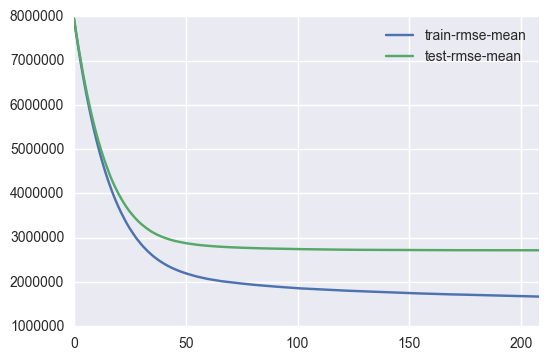

In [8]:
y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True) 

model, output = get_xgboost_results()
#test['xgb1'] = output['price_doc']

## Model Training: Feature Importance

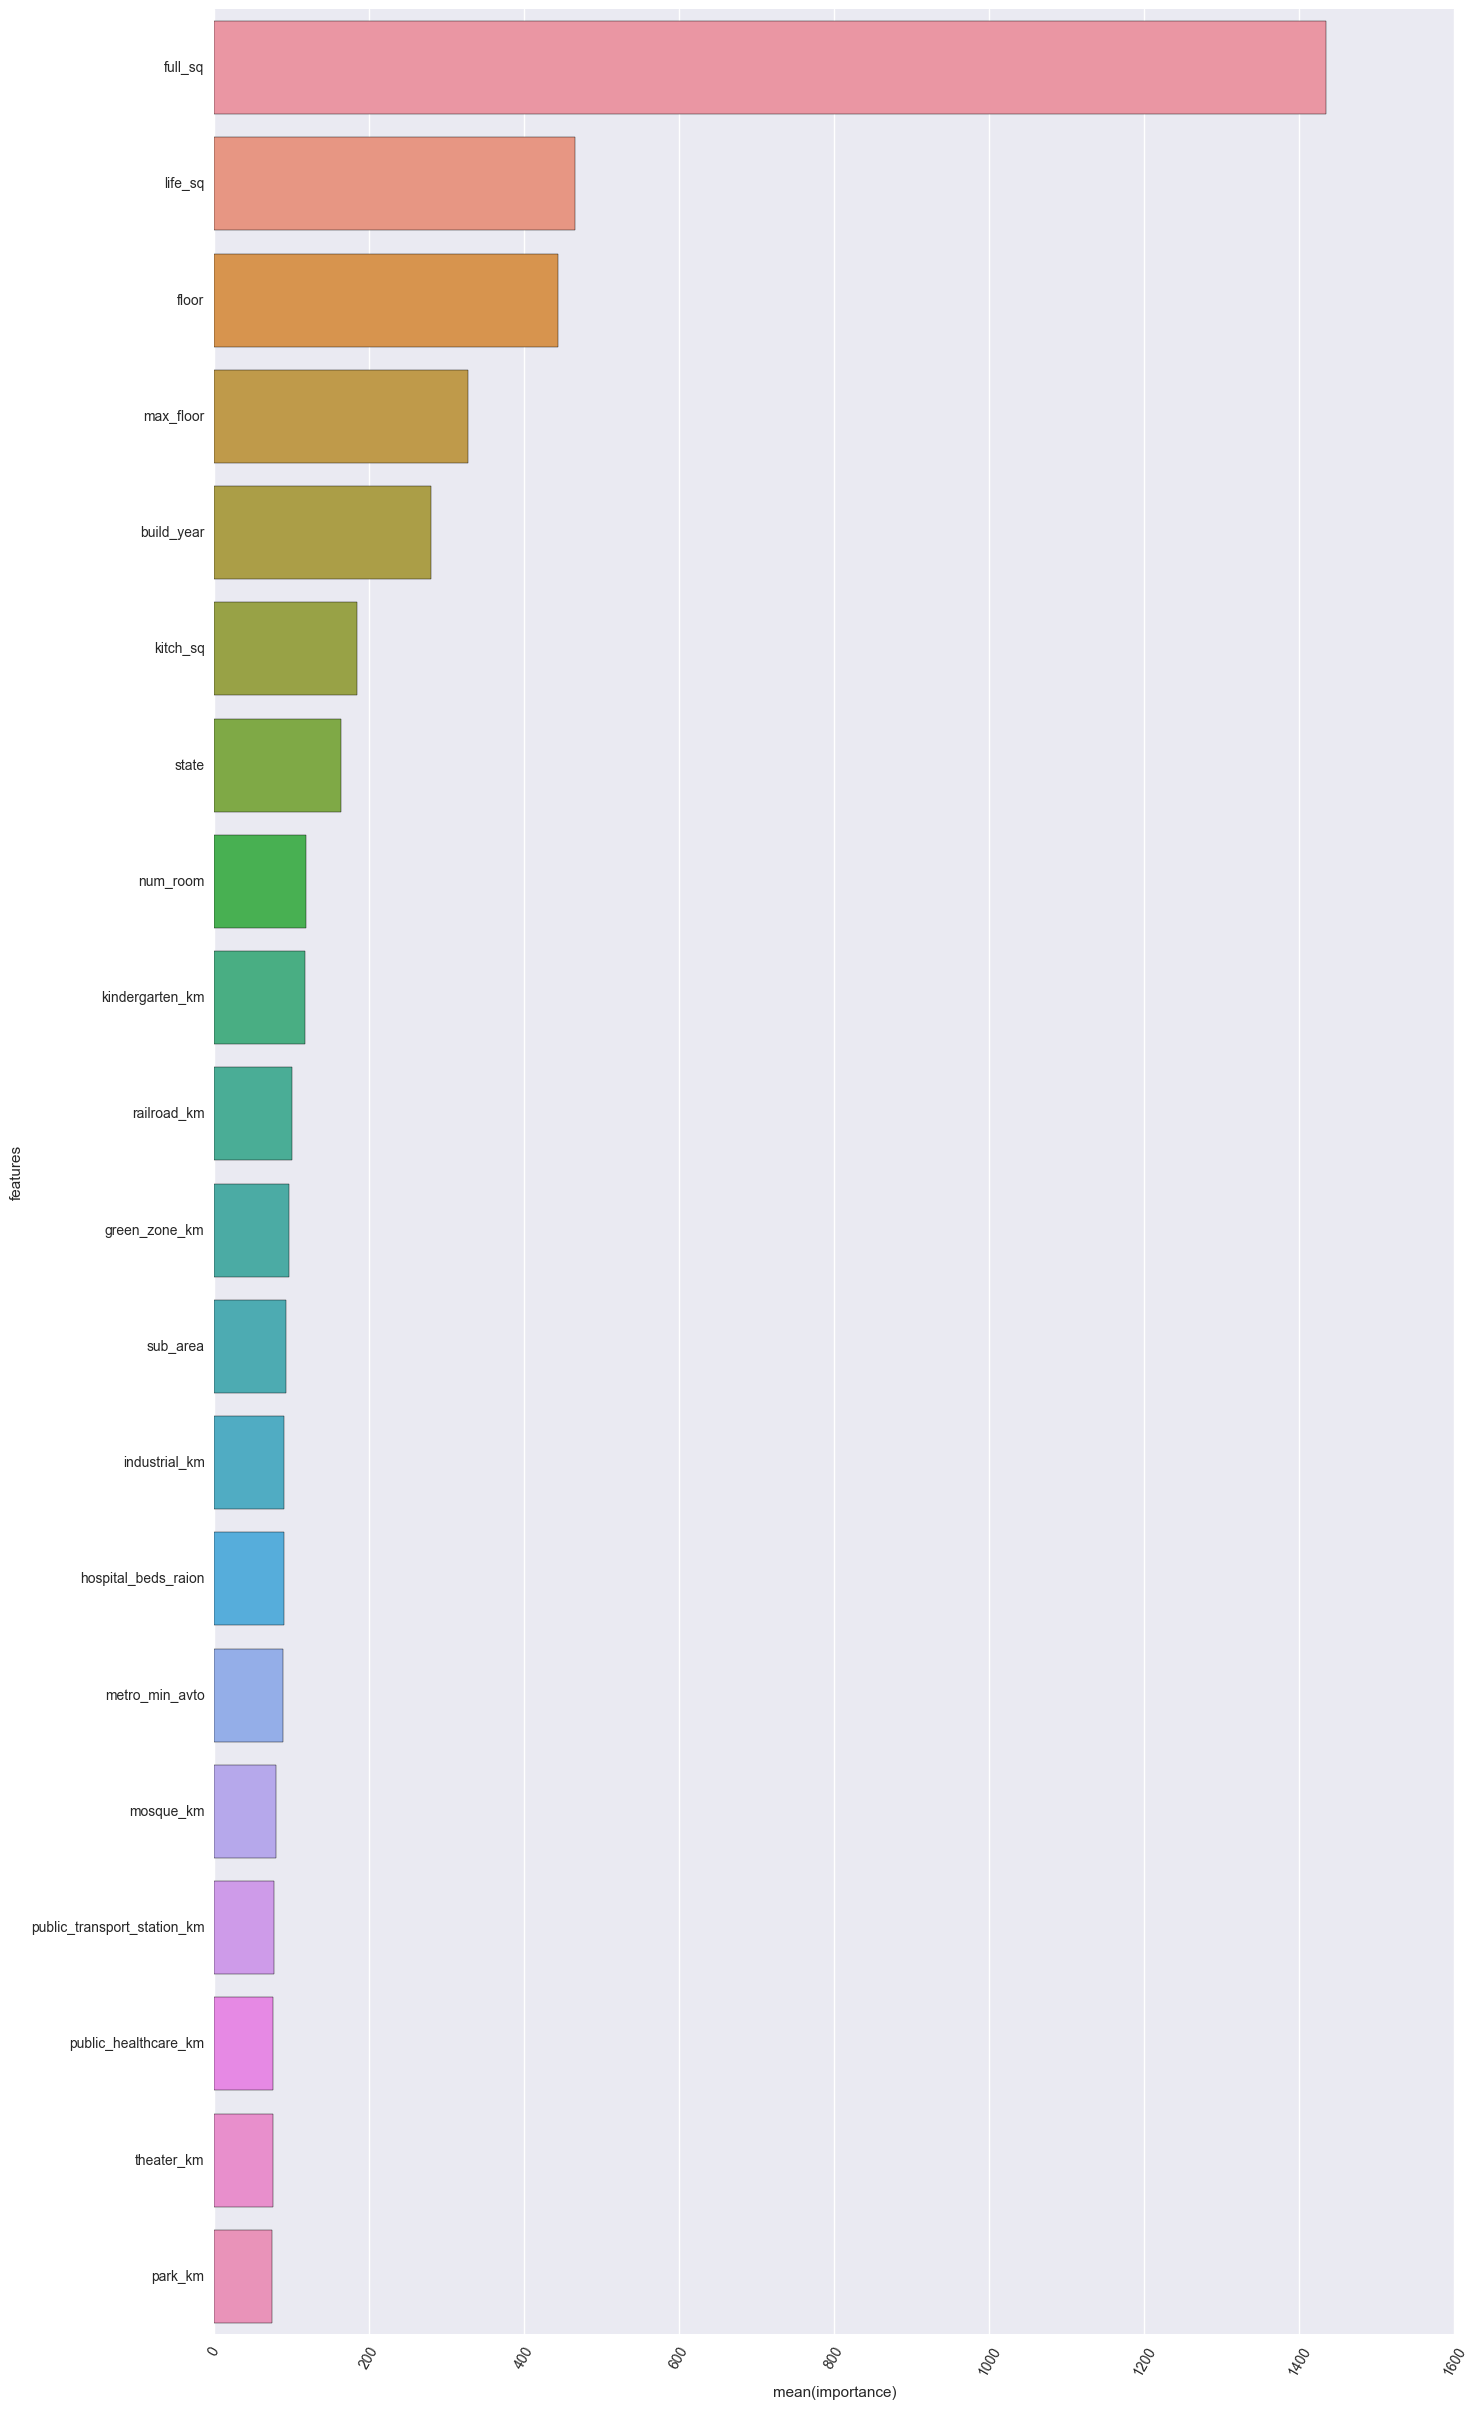

In [9]:
def plot_feature_importance():
    featureImportance = model.get_fscore()
    features = pd.DataFrame()
    features['features'] = featureImportance.keys()
    features['importance'] = featureImportance.values()
    features.sort_values(by=['importance'],ascending=False,inplace=True)
    fig,ax= plt.subplots()
    fig.set_size_inches(16,30)
    plt.xticks(rotation=60)
    sns.set(font_scale=2.5)
    #sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")
    sns.barplot(data=features.head(20),x="importance",y="features",ax=ax) #,orient="v")
    
if (1): plot_feature_importance()